In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical


train_csv = "features_fixed.csv"
dev_csv   = r"C:\LibriSpeech\features_dev_fixed.csv"
test_csv  = r"C:\LibriSpeech\features_test_fixed.csv"

df_train = pd.read_csv(train_csv)
df_dev = pd.read_csv(dev_csv)
df_test = pd.read_csv(test_csv)


features = [
    'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 
    'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13',
    'Chroma_1', 'Chroma_2', 'Chroma_3', 'Chroma_4', 'Chroma_5', 'Chroma_6', 
    'Chroma_7', 'Chroma_8', 'Chroma_9', 'Chroma_10', 'Chroma_11', 'Chroma_12',
    'Spectral_Centroid', 'Spectral_Bandwidth', 'Rolloff', 'Zero_Crossing_Rate', 'RMSE'
]

X_train = df_train[features].values
y_train = df_train['Speaker_ID'].values

X_dev = df_dev[features].values
y_dev = df_dev['Speaker_ID'].values

X_test = df_test[features].values
y_test = df_test['Speaker_ID'].values


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)


le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_dev_enc = le.transform(y_dev)
y_test_enc = le.transform(y_test)

num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_dev_cat = to_categorical(y_dev_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)


timesteps = 20  
features = 13  

num_samples = X_train_scaled.shape[0]


total_elements = X_train_scaled.shape[0] * X_train_scaled.shape[1]
print(f"Total elements in original data: {total_elements}")


required_elements = num_samples * timesteps * features
print(f"Required elements for reshaping: {required_elements}")


if total_elements % required_elements == 0:
   
    X_train_seq = X_train_scaled.reshape(num_samples, timesteps, features)
    X_dev_seq = X_dev_scaled.reshape(X_dev_scaled.shape[0], timesteps, features)
    X_test_seq = X_test_scaled.reshape(X_test_scaled.shape[0], timesteps, features)
    
    print(f"X_train_seq shape: {X_train_seq.shape}")
    print(f"X_dev_seq shape: {X_dev_seq.shape}")
    print(f"X_test_seq shape: {X_test_seq.shape}")
else:
    print("The total number of elements does not match the required number for reshaping.")


Total elements in original data: 856170
Required elements for reshaping: 7420140
The total number of elements does not match the required number for reshaping.


In [ ]:
timesteps = 1  
features = X_train_scaled.shape[1]  


num_samples = X_train_scaled.shape[0]


X_train_seq = X_train_scaled.reshape(num_samples, timesteps, features)
X_dev_seq = X_dev_scaled.reshape(X_dev_scaled.shape[0], timesteps, features)
X_test_seq = X_test_scaled.reshape(X_test_scaled.shape[0], timesteps, features)

print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"X_dev_seq shape: {X_dev_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")


X_train_seq shape: (28539, 1, 30)
X_dev_seq shape: (2825, 1, 30)
X_test_seq shape: (2913, 1, 30)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout


model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=(1, 30)),  # 64 LSTM units
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


history = model.fit(X_train_seq, y_train_cat, 
                    epochs=30, batch_size=64,
                    validation_data=(X_dev_seq, y_dev_cat))


test_loss, test_accuracy = model.evaluate(X_test_seq, y_test_cat)
print(f"Test Accuracy: {test_accuracy:.4f}")


y_pred = np.argmax(model.predict(X_test_seq), axis=1)
print(classification_report(y_test_enc, y_pred))


C:\Users\opsb2\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 128)                 │          48,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 251)                 │          16,315 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,211 (285.98 KB)

 Trainable params: 73,211 (285.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.1276 - loss: 4.5674 - val_accuracy: 0.6188 - val_loss: 1.6735
Epoch 2/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6332 - loss: 1.5214 - val_accuracy: 0.8322 - val_loss: 0.7296
Epoch 3/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7592 - loss: 0.9258 - val_accuracy: 0.8772 - val_loss: 0.5028
Epoch 4/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8217 - loss: 0.6786 - val_accuracy: 0.9002 - val_loss: 0.3893
Epoch 5/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8460 - loss: 0.5613 - val_accuracy: 0.8920 - val_loss: 0.3884
Epoch 6/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8610 - loss: 0.4957 - val_accuracy: 0.9122 - val_loss: 0.3242
Epoch 7/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8784 - loss: 0.4257 - val_accuracy: 0.9352 - val_loss: 0.2402
Epoch 8/30
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8860 - loss: 0.3974 - val_accuracy: 0.

C:\Users\opsb2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\opsb2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\opsb2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

X_train = df_train.drop(columns=['Speaker_ID', 'Chapter_ID', 'File_Name'])
X_test = df_test.drop(columns=['Speaker_ID', 'Chapter_ID', 'File_Name'])


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(df_train['Speaker_ID'])
y_test = le.transform(df_test['Speaker_ID'])


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense




X_train = df_train.drop(columns=['Speaker_ID', 'Chapter_ID', 'File_Name'])
X_test = df_test.drop(columns=['Speaker_ID', 'Chapter_ID', 'File_Name'])


le = LabelEncoder()
y_train = le.fit_transform(df_train['Speaker_ID'])
y_test = le.transform(df_test['Speaker_ID'])


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = Sequential()


model.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.5))


model.add(Dense(64, activation='relu'))
model.add(Dense(len(le.classes_), activation='softmax')) 

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


X_train = X_train[..., np.newaxis]  
X_test = X_test[..., np.newaxis]


history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")



Epoch 1/30


C:\Users\opsb2\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.0501 - loss: 4.6812 - val_accuracy: 0.1346 - val_loss: 3.5534
Epoch 2/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2127 - loss: 3.1265 - val_accuracy: 0.2204 - val_loss: 3.0194
Epoch 3/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3303 - loss: 2.5908 - val_accuracy: 0.3714 - val_loss: 2.4912
Epoch 4/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.3846 - loss: 2.2932 - val_accuracy: 0.4157 - val_loss: 2.3031
Epoch 5/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4223 - loss: 2.1424 - val_accuracy: 0.4432 - val_loss: 2.1053
Epoch 6/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4530 - loss: 2.0130 - val_accuracy: 0.4555 - val_loss: 2.0474
Epoch 7/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4665 - loss: 1.9646 - val_accuracy: 0.4748 - val_loss: 1.9852
Epoch 8/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4870 - loss: 1.8721 - val_accuracy: 0.4885 - v

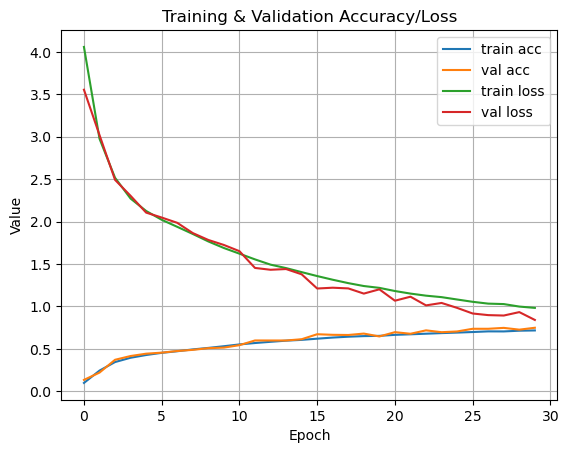

In [84]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.grid(True)
plt.title('Training & Validation Accuracy/Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()


In [ ]:
!pip install keras_tuner
import keras_tuner as kt
from tensorflow.keras import layers, models

def quick_model_builder(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))

    
    lstm_units = hp.Choice('lstm_units', values=[64, 128])
    model.add(layers.Bidirectional(layers.LSTM(units=lstm_units)))

    
    dropout_rate = hp.Choice('dropout_rate', values=[0.3, 0.5])
    model.add(layers.Dropout(dropout_rate))

    
    dense_units = hp.Choice('dense_units', values=[64, 128])
    model.add(layers.Dense(dense_units, activation='relu'))

    
    model.add(layers.Dense(num_classes, activation='softmax'))

    
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [94]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)


In [ ]:
tuner = kt.RandomSearch(
    quick_model_builder,
    objective='val_accuracy',
    max_trials=5,  
    directory='quick_tuning',
    project_name='bilstm_quick'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(X_train, y_train_cat,
             epochs=15,
             validation_data=(X_test, y_test_cat),
             callbacks=[stop_early])


Trial 5 Complete [00h 02m 07s]
val_accuracy: 0.7346378564834595

Best val_accuracy So Far: 0.7346378564834595
Total elapsed time: 00h 09m 48s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Config:")
for param in ['lstm_units', 'dense_units', 'dropout_rate', 'learning_rate']:
    print(f"{param}: {best_hps.get(param)}")


model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train_cat,
          validation_data=(X_test, y_test_cat),
          epochs=15)



Best Config:
lstm_units: 64
dense_units: 128
dropout_rate: 0.3
learning_rate: 0.001
Epoch 1/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.0704 - loss: 4.4571 - val_accuracy: 0.1878 - val_loss: 3.1308
Epoch 2/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.3062 - loss: 2.6969 - val_accuracy: 0.3402 - val_loss: 2.4904
Epoch 3/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4110 - loss: 2.1937 - val_accuracy: 0.4325 - val_loss: 2.1102
Epoch 4/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4688 - loss: 1.9233 - val_accuracy: 0.4298 - val_loss: 2.0318
Epoch 5/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5139 - loss: 1.7642 - val_accuracy: 0.4658 - val_loss: 1.9237
Epoch 6/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5588 - loss: 1.5955 - val_accuracy: 0.5342 - val_loss: 1.6475
Epoch 7/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5972 - loss: 1.4413 - val_accuracy: 0.5709 - val_loss: 1.5284
Epoch 8/15
89

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

# Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)


def build_bilstm_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Attention()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
model = build_bilstm_attention_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=251)
model.summary()

from tensorflow.keras.utils import to_categorical


y_train_one_hot = to_categorical(y_train, num_classes=251)
y_test_one_hot = to_categorical(y_test, num_classes=251)


history = model.fit(X_train, y_train_one_hot,
                    validation_data=(X_test, y_test_one_hot),
                    epochs=15,
                    batch_size=32)



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 30, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_1 (Attention)              │ (None, 256)                 │             286 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,681 (776.10 KB)

 Trainable params: 198,681 (776.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.0266 - loss: 4.8491 - val_accuracy: 0.0899 - val_loss: 3.7836
Epoch 2/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.1318 - loss: 3.6411 - val_accuracy: 0.1411 - val_loss: 3.3427
Epoch 3/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.2337 - loss: 3.0628 - val_accuracy: 0.2853 - val_loss: 2.8357
Epoch 4/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.3203 - loss: 2.6332 - val_accuracy: 0.3677 - val_loss: 2.3637
Epoch 5/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.3899 - loss: 2.3048 - val_accuracy: 0.4257 - val_loss: 2.1349
Epoch 6/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4392 - loss: 2.1094 - val_accuracy: 0.4693 - val_loss: 2.0186
Epoch 7/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4732 - loss: 1.9429 - val_accuracy: 0.5132 - val_loss: 1.7472
Epoch 8/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5178 - loss: 1.7917 - 

In [108]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history =  model.fit(X_train, y_train_one_hot,
                    validation_data=(X_test, y_test_one_hot),
                    epochs=30,
                    batch_size=32,callbacks=[early_stop])


Epoch 1/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6902 - loss: 1.0944 - val_accuracy: 0.7418 - val_loss: 0.8571
Epoch 2/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7061 - loss: 1.0342 - val_accuracy: 0.7645 - val_loss: 0.8159
Epoch 3/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7171 - loss: 0.9985 - val_accuracy: 0.7635 - val_loss: 0.7967
Epoch 4/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7344 - loss: 0.9395 - val_accuracy: 0.7741 - val_loss: 0.7484
Epoch 5/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7360 - loss: 0.9126 - val_accuracy: 0.7975 - val_loss: 0.6697
Epoch 6/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7514 - loss: 0.8566 - val_accuracy: 0.7800 - val_loss: 0.7143
Epoch 7/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7548 - loss: 0.8268 - val_accuracy: 0.8332 - val_loss: 0.5617
Epoch 8/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7685 - loss: 0.7974 - 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


checkpoint = ModelCheckpoint(
    filepath='best_bilstm_attention_model.h5',  
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)


history = model.fit(
    X_train, y_train_one_hot,
    validation_data=(X_test, y_test_one_hot),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/30
889/892 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8862 - loss: 0.3454
Epoch 1: val_loss improved from inf to 0.13411, saving model to best_bilstm_attention_model.h5


892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8862 - loss: 0.3455 - val_accuracy: 0.9643 - val_loss: 0.1341
Epoch 2/30
890/892 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8898 - loss: 0.3417
Epoch 2: val_loss did not improve from 0.13411
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8898 - loss: 0.3417 - val_accuracy: 0.9574 - val_loss: 0.1404
Epoch 3/30
890/892 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8929 - loss: 0.3288
Epoch 3: val_loss did not improve from 0.13411
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8929 - loss: 0.3288 - val_accuracy: 0.9616 - val_loss: 0.1372
Epoch 4/30
891/892 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8988 - loss: 0.3153
Epoch 4: val_loss did not improve from 0.13411
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8988 - loss: 0.3154 - val_accuracy: 0.9561 - val_loss: 0.1356
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [114]:
model.save("best_bilstm_attention_model.keras")


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Attention, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical



input_shape = X_train.shape[1:]  
num_classes = y_train_one_hot.shape[1]


inputs = Input(shape=input_shape)
lstm_out = Bidirectional(LSTM(128, return_sequences=True))(inputs)
attention_out = Attention()([lstm_out, lstm_out])  # Correct usage: list of [query, value]
output = Dense(num_classes, activation='softmax')(attention_out[:, -1, :])  # Pick last timestep after attention

model = Model(inputs, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_bilstm_attention_model.keras', monitor='val_loss', save_best_only=True)


history = model.fit(
    X_train, y_train_one_hot,
    validation_data=(X_test, y_test_one_hot),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.0346 - loss: 4.7860 - val_accuracy: 0.0687 - val_loss: 3.9945
Epoch 2/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.1883 - loss: 3.3790 - val_accuracy: 0.2345 - val_loss: 3.1505
Epoch 3/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.3432 - loss: 2.5700 - val_accuracy: 0.3845 - val_loss: 2.4002
Epoch 4/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4859 - loss: 1.9540 - val_accuracy: 0.4782 - val_loss: 1.9760
Epoch 5/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5642 - loss: 1.6082 - val_accuracy: 0.5287 - val_loss: 1.7440
Epoch 6/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.6170 - loss: 1.3939 - val_accuracy: 0.5647 - val_loss: 1.6197
Epoch 7/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.6674 - loss: 1.2101 - val_accuracy: 0.5946 - val_loss: 1.4565
Epoch 8/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.6979 - loss: 1.0870 - 

In [122]:
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9720 - loss: 0.1297
Test Accuracy: 0.9691, Test Loss: 0.1364


In [124]:
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9720 - loss: 0.1297
Test Accuracy: 0.9691, Test Loss: 0.1364


In [128]:
from tensorflow.keras.models import load_model

try:
    model = load_model("best_bilstm_attention_model.keras")
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")


Model loaded successfully!


In [6]:
from tensorflow.keras.models import load_model

try:
    model = load_model("best_bilstm_attention_model.keras")
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")


Model loaded successfully!


In [ ]:
import numpy as np
import librosa
import tensorflow as tf


model = tf.keras.models.load_model("best_bilstm_attention_model.keras")


audio_path = "61-70968-0001.wav"  


y, sr = librosa.load(audio_path, sr=None)


mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)


if mfcc.shape[1] < 30:
    pad_width = 30 - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0,0),(0, pad_width)), mode='constant')
else:
    mfcc = mfcc[:, :30]


mfcc_mean = np.mean(mfcc, axis=0)


input_data = mfcc_mean.reshape(1, 30, 1)


prediction = model.predict(input_data)
predicted_label = np.argmax(prediction)

print(f"Predicted Speaker_ID: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
Predicted Speaker_ID: 227
